# Number of Training Jets

Ok, so it seems like even training on 3m hybrid events is not sufficient, so I'm going to compare the performance when I increase the size of the training set.


In [2]:
import numpy as np
import h5py
import sys
import pandas as pd
import xarray as xr

sys.path.append("../..")
from usefulFcts import *
from trainNet import *
from plottingFcts import *

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [3]:
HYBRID_SAMPLE = "hybrid_1.5TeV"

**Load in the test dataset**

Since my roc curves weren't bumpy, I have enough statitics in my test set, so I'm fine using the same test set for evaluating all of these models.

I'm going to be evaluating these models on the ttbar test set.

In [4]:
dataDir = '../../data/mc16d_PFlow_ttbar'
vStr = "sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits"
dataTag = "2mtest_15trks_{}_sd0_rev_{}_scale".format(vStr,HYBRID_SAMPLE)

f_name = "{}/data_{}.hdf5".format(dataDir,dataTag)

f = h5py.File(f_name,"r")

X = f['X_test'][:]
y = f['y_test'][:]
ix = f['ix_test'][:]

f.close()

nTest,nTrks,nFeatures = X.shape

**Plan:** Loop through the options for the # of training jets, and see if this has allowed you to converge to a more optimal solution.

In [5]:
subDir = 'mc16d_PFlow_{}'.format(HYBRID_SAMPLE)
figDir = '../../figures/'
modelDir = '../../models/'+subDir

Initialize method from myModel()
Loading previously trained LSTM
acc
loss
val_acc
val_loss


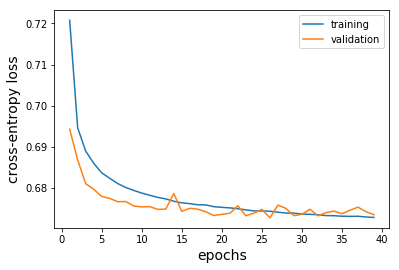

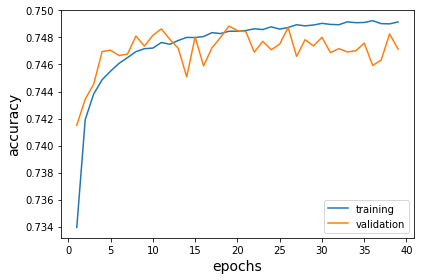

Load in the previously saved efficiency file
Initialize method from myModel()
Loading previously trained LSTM
acc
loss
val_acc
val_loss


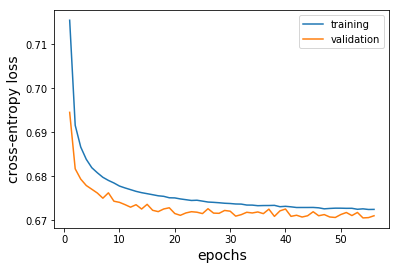

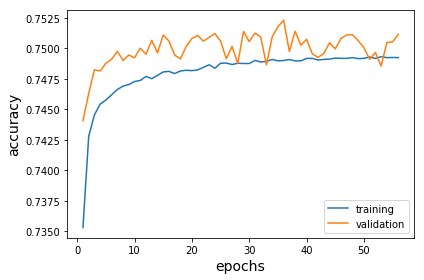

Load in the previously saved efficiency file
Initialize method from myModel()
Loading previously trained LSTM
acc
loss
val_acc
val_loss


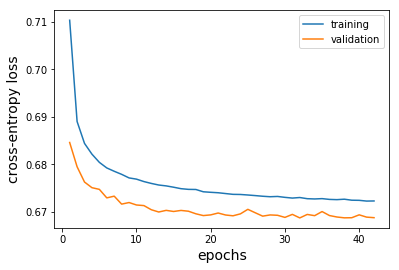

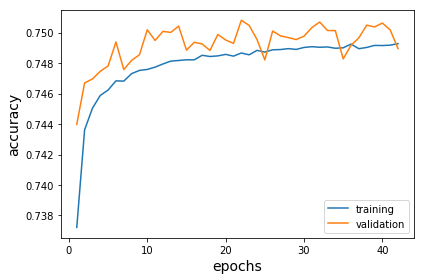

Load in the previously saved efficiency file


In [6]:
leffs, ceffs, beffs = [],[],[]

for nMillion in [3,4,5]:

    dataTagTrain = "{}mtrain_15trks_{}_sd0_rev".format(nMillion,vStr)
    
    m = myLSTM(modelDir=modelDir, nFeatures=nFeatures, dataTag=dataTagTrain, loadModel=True)
    trainingMetrics(m.modelName,modelDir=modelDir)

    # Get the efficiencies
    (leff, ceff, beff), d = getEffs(m, X, y, ix, returnDisc=True,
                                    figDir=figDir,subDir=subDir,modelDir=modelDir)

    leffs.append(leff)
    ceffs.append(ceff)
    beffs.append(beff)
    #discs.append(d)
    

**Note on optimizers**

Since the accuracy seems more noisy than the loss, should I be using the loss for an early stopping metric instead of the accuracy?

../../plottingFcts.py:549: RuntimeWarning: invalid value encountered in sqrt
  eff_err = lambda x, N: np.sqrt( x*(1-x) / N)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:117: RuntimeWarning: invalid value encountered in multiply
  d = ((2*h0 + h1)*m0 - h0*m1) / (h0 + h1)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:147: RuntimeWarning: invalid value encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk


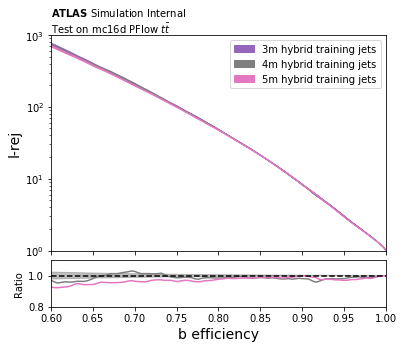

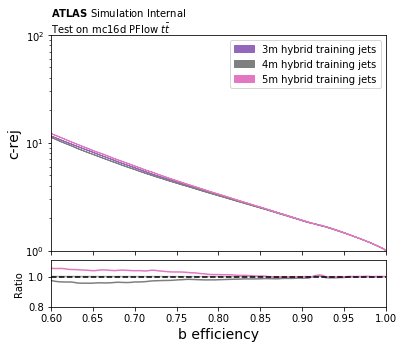

In [7]:
labels=['{}m hybrid training jets'.format(x) for x in [3,4,5]]
plotTag = 'rej_ttbar_vary_nTrain'

text="$\mathbf{ATLAS}$ Simulation Internal\n"
text+=r"Test on mc16d PFlow $t\bar{t}$"

colors = ['C4','C7','C6']

plotROCRatio(beffs, leffs, labels, rrange=(0.8,1.1),ymax=1000,
             text=text,ylabel='l-rej',binomialErrors=True,nTest=nTest, 
             colors=colors, figDir=figDir,
             subDir=subDir,tag='l'+plotTag)

plotROCRatio(beffs, ceffs, labels, rrange=(0.8,1.11),ymax=100,
             text=text,ylabel='c-rej',binomialErrors=True,nTest=nTest, 
             colors=colors, figDir=figDir,
             subDir=subDir,tag='c'+plotTag)

**Lesson:** In terms of the l-rejection, it doesn't seem like it's an issue was with underfitting, because adding more training events did *not* fix the problem.

I'm going to look into the reweighting, but I think that another avenue that I might try is looking into the weights for the class probability, because it might just be learning the prior distribution for background composition between the Z' and $t\bar{t}$ samples.